In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
df = pd.read_csv('../../mlops_data/TA_data.csv')

In [4]:
df.head(5)

,날짜,TA_AVG,TA_MAX,TA_MIN
0,1907-10-01,13.5,20.7,7.9
1,1907-10-02,16.2,22.0,7.9
2,1907-10-03,16.2,21.3,13.1
3,1907-10-04,16.5,22.0,11.2
4,1907-10-05,17.6,25.4,10.9


In [5]:
df.shape[0]

41787

In [6]:
WINDOW_SIZE = 30

In [7]:
outputs = ["TA_AVG", "TA_MAX", "TA_MIN"]

In [8]:
features = df[outputs].values
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [9]:
def create_lstm_sequences(values, window_size=7):
    X, y = [], []
    for i in range(len(values) - window_size):
        X.append(values[i:i+window_size])
        y.append(values[i+window_size])
    return np.array(X), np.array(y)

In [10]:
X, y = create_lstm_sequences(features_scaled, window_size=WINDOW_SIZE)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025)

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

print(f"X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}")

X_train shape: torch.Size([33405, 30, 3]), y_train shape: torch.Size([33405, 3])


In [13]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)

In [14]:
class MultiOutputLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, len(outputs))
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [15]:
model = MultiOutputLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
train_losses, val_losses = [], []
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            loss = criterion(model(Xb), yb)
            val_loss += loss.item() * Xb.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"[{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

[1/20] Train Loss: 0.0194, Val Loss: 0.0007
[2/20] Train Loss: 0.0007, Val Loss: 0.0007
[3/20] Train Loss: 0.0007, Val Loss: 0.0006
[4/20] Train Loss: 0.0006, Val Loss: 0.0006
[5/20] Train Loss: 0.0006, Val Loss: 0.0005
[6/20] Train Loss: 0.0006, Val Loss: 0.0005
[7/20] Train Loss: 0.0006, Val Loss: 0.0005
[8/20] Train Loss: 0.0005, Val Loss: 0.0005
[9/20] Train Loss: 0.0005, Val Loss: 0.0004
[10/20] Train Loss: 0.0005, Val Loss: 0.0005
[11/20] Train Loss: 0.0005, Val Loss: 0.0004
[12/20] Train Loss: 0.0004, Val Loss: 0.0004
[13/20] Train Loss: 0.0004, Val Loss: 0.0004
[14/20] Train Loss: 0.0004, Val Loss: 0.0004
[15/20] Train Loss: 0.0004, Val Loss: 0.0004
[16/20] Train Loss: 0.0004, Val Loss: 0.0004
[17/20] Train Loss: 0.0004, Val Loss: 0.0004
[18/20] Train Loss: 0.0004, Val Loss: 0.0004
[19/20] Train Loss: 0.0004, Val Loss: 0.0004
[20/20] Train Loss: 0.0004, Val Loss: 0.0004


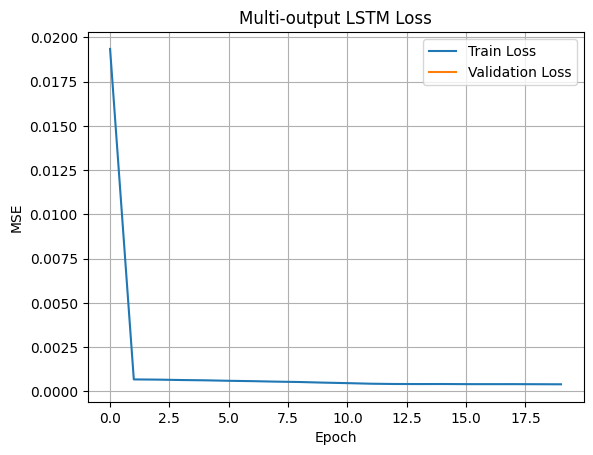

In [17]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.title("Multi-output LSTM Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
torch.save(model.state_dict(), "../../models/lstm_model.pth")

In [19]:
model.load_state_dict(torch.load("../../models/lstm_model.pth", map_location=torch.device("cpu")))
model.to(device)

MultiOutputLSTM(
  (lstm): LSTM(3, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

In [20]:
fake_test_data = np.random.normal(loc=15, scale=3, size=(WINDOW_SIZE, len(outputs)))
fake_test_data.shape

(30, 3)

In [21]:
model.eval()
with torch.no_grad():
    input_scaled = scaler.transform(fake_test_data)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).unsqueeze(0).to(device)
    output = model(input_tensor)
    prediction = output.cpu().numpy().squeeze()
    result = scaler.inverse_transform([prediction])

In [22]:
print(f"{outputs[0]}: {result[0][0]}, {outputs[1]}: {result[0][1]}, {outputs[2]}: {result[0][2]}")

TA_AVG: 11.34377456903457, TA_MAX: 15.738206863403319, TA_MIN: 7.091260939836518
